In [1]:
import torch
import numpy as np
import time
import os

import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert, complete_box_iou
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_targets

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

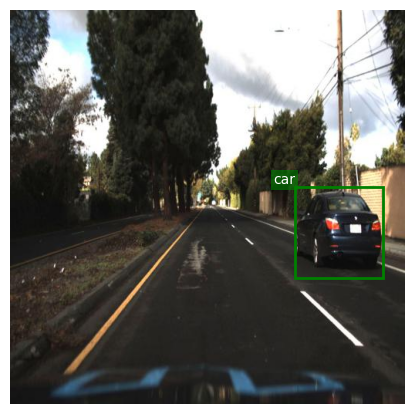

In [2]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

toy_set = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=min_tfms, file_pct=1, rand_seed=724, device='cpu')

toy_set.show_with_box(index=123, color='g', lw=2, label=True);

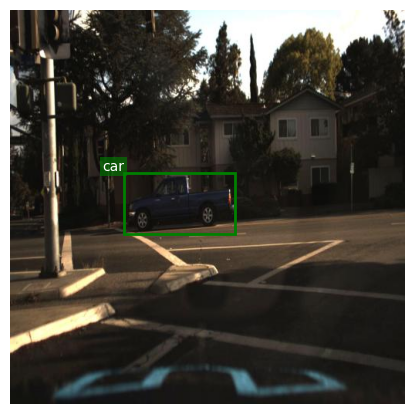

In [3]:
toy_set.show_with_box(index=0, color='g', lw=2, label=True);

In [4]:
toy_dataloader = DataLoader(toy_set, 
                              batch_size=1, 
                              shuffle=False, 
                              num_workers=0,
                              collate_fn=collate_detection
                              )

(images, targets) = next(iter(toy_dataloader))

# send to device
# images tensor is normalized (i.e. values between 0 and 1)
# need to normalize target bounding boxes
images = images.to(device)
for i in range(len(targets)):
    for key in targets[i]:
        targets[i][key] = targets[i][key].to(device=device)
        if key == 'boxes':
            targets[i][key] = targets[i][key] / torch.tensor([512, 512, 512, 512], device=device, dtype=torch.float32)

Step 1 - create prior boxes

In [5]:
priors = mySSD.create_default_boxes()
priors_xyxy = box_convert(boxes=priors, in_fmt='cxcywh', out_fmt='xyxy').clamp(0, 1)

priors_xyxy_38 = priors_xyxy[0:38*38*4]
priors_xyxy_19 = priors_xyxy[38*38*4:38*38*4+19*19*6]
priors_xyxy_10 = priors_xyxy[38*38*4+19*19*6:38*38*4+19*19*6+10*10*6]
priors_xyxy_5 = priors_xyxy[38*38*4+19*19*6+10*10*6:38*38*4+19*19*6+10*10*6+5*5*6]
priors_xyxy_3 = priors_xyxy[38*38*4+19*19*6+10*10*6+5*5*6:38*38*4+19*19*6+10*10*6+5*5*6+3*3*4]
priors_xyxy_1 = priors_xyxy[38*38*4+19*19*6+10*10*6+5*5*6+3*3*4:38*38*4+19*19*6+10*10*6+5*5*6+3*3*4+1*1*4]

Step 2 - determine which prior box matches the 'best' with the ground truth box

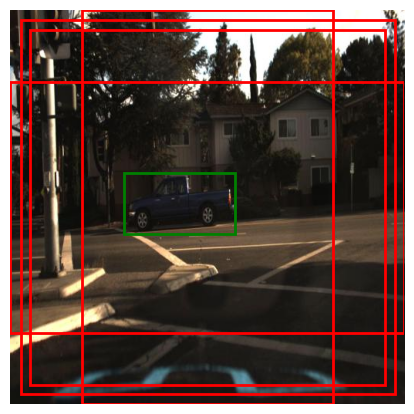

In [6]:
toy_set.show_with_box(index=0, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy_1}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

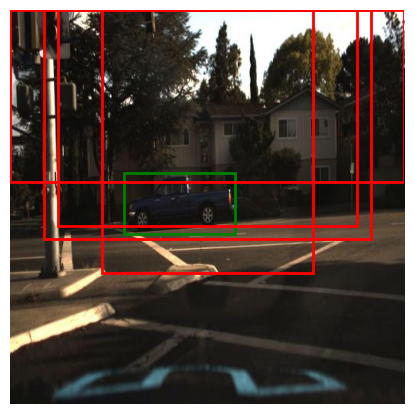

In [7]:
toy_set.show_with_box(index=0, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy_3[4:8]}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

In [6]:
def make_priors_gif(toy_set, priors_xyxy, gif_path, mult, n_start=0, n_end=9, duration=500):

    if (mult != 1) & (mult != 4) & (mult != 6):
        raise ValueError(f"mult should be 1, 4 or 6, recieved {mult}.")
    frames = []

    for n in range(n_start, n_end):
        # Get the figure that show_with_box actually creates
        fig = toy_set.show_with_box(
            index=0,
            color='g',
            lw=2,
            label=False,
            pred_dict={"boxes": priors_xyxy[mult*n:mult*(n+1)]},
            pred_color='r',
            lw_pred=2,
            pred_label=False,
            pred_ref='normalized'
        )

                # Render and grab pixels
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()

        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        buf = buf.reshape((h, w, 4))  # [H, W, 4]

        # Take the first axes (assuming show_with_box creates one main axes)
        ax = fig.axes[0]
        bbox = ax.get_window_extent()  # in display (pixel) coords
        x0, y0, x1, y1 = bbox.extents
        x0, y0, x1, y1 = [int(v) for v in (x0, y0, x1, y1)]

        # Crop to axes region
        buf_cropped = buf[y0:y1, x0:x1, :]  # [h_c, w_c, 4]
        img = buf_cropped[..., :3].copy()   # RGB

        # ---- Add a small white border around the cropped image ----
        border = 4  # adjust this to taste
        h_c, w_c, _ = img.shape

        # White background (255,255,255)
        framed = np.full(
            (h_c + 2*border, w_c + 2*border, 3),
            255,
            dtype=np.uint8
        )

        # Put the image in the center
        framed[border:border + h_c, border:border + w_c, :] = img

        frames.append(framed)

        plt.close(fig)

    imageio.mimsave(gif_path, frames, duration=duration, loop=0)
    return gif_path

In [47]:
make_priors_gif(toy_set, priors_xyxy_3, mult=4, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_3.gif",
                           n_start=0, n_end=3*3, duration=500)
make_priors_gif(toy_set, priors_xyxy_5, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_5.gif",
                           n_start=0, n_end=5*5, duration=500)
make_priors_gif(toy_set, priors_xyxy_10, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_10.gif",
                           n_start=0, n_end=10*10, duration=500)
make_priors_gif(toy_set, priors_xyxy_19, mult=6, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_19.gif",
                           n_start=0, n_end=19*19, duration=100)
make_priors_gif(toy_set, priors_xyxy_38, mult=4, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_38.gif",
                           n_start=0, n_end=38*38, duration=50)

'C:\\Users\\eblac\\OneDrive\\Documents\\GitHub\\self-driving-car\\figures\\priors_38.gif'

We can visualize all of the priors on our image.  The .gif below shows all priors corresponding to the conv_8_2 layer, with a total of 10 * 10 * 6 = 600 boxes.

![description](figures/priors_10.gif)

Step 3 - compute IoU between ground truth box and each prior box to find best match

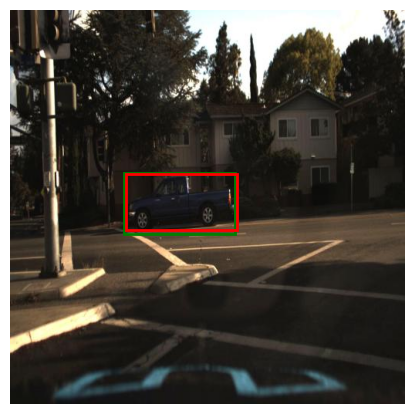

In [8]:
# IoU and matching
iou = complete_box_iou(priors_xyxy, targets[0]['boxes'])           # [P,G]
# Force bipartite matches: each GT gets its best prior
best_prior_per_gt = iou.argmax(dim=0)

toy_set.show_with_box(index=0, color='g', lw=2, label=False, pred_dict={"boxes": priors_xyxy[best_prior_per_gt]}, pred_color='r', lw_pred=2, pred_label=False, pred_ref='normalized');

In [9]:
# this guarantees the selection of atleast this prior
# example: best IoU is 0.3 but IoU threshold is 0.5
iou[best_prior_per_gt, torch.arange(1, device=device)] = 2.0

In [10]:
# this gets us the index of priors with IoU >= 0.5
best_gt_per_prior  = iou.argmax(dim=1)
best_iou_per_prior = iou.gather(1, best_gt_per_prior.view(-1,1)).squeeze(1)
pos_mask = best_iou_per_prior >= 0.5 # 0.5 was chosen as IoU threshold
print(pos_mask)

tensor([False, False, False,  ..., False, False, False])


In [46]:
make_priors_gif(toy_set, priors_xyxy[pos_mask], mult=1, gif_path=r"C:\Users\eblac\OneDrive\Documents\GitHub\self-driving-car\figures\priors_above_threshold.gif",
                           n_start=0, n_end=priors_xyxy[pos_mask].shape[0], duration=500)

'C:\\Users\\eblac\\OneDrive\\Documents\\GitHub\\self-driving-car\\figures\\priors_above_threshold.gif'

Now we can visualize all priors above the IoU threshold of 0.5!

![Priors above IoU threshold](figures/priors_above_threshold.gif)

In [18]:
# Since there is only 1 target ground truth box, matched_gt_cxcywh is just the only GT box repeated 8732 times
# This structure is important for handling multiple GT boxes in an image
gt_boxes_cxcywh = box_convert(targets[0]['boxes'], in_fmt='xyxy', out_fmt='cxcywh').to(device=device)
matched_gt_cxcywh = gt_boxes_cxcywh[best_gt_per_prior]  # [P,4]

In [19]:
# Encode offsets (inverse of SSD decode)
v_c, v_s = (0.1, 0.2) # variances
t_xy = (matched_gt_cxcywh[:, :2] - priors[:, :2]) / priors[:, 2:] / v_c
t_wh = torch.log(
    (matched_gt_cxcywh[:, 2:] / priors[:, 2:]).clamp(min=1e-12)
) / v_s

loc_target = torch.zeros_like(priors)
loc_target[:, :2] = t_xy
loc_target[:, 2:] = t_wh